In [1]:
# -*- coding: utf-8 -*-

"""
Created January 9, 2023
"""

import os
import pickle

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.misc as misc
import scipy.ndimage as ndimage
import scipy.spatial as spatial
from tqdm.notebook import tqdm


DICOM_METADATA_PATH = (
    "/dartfs-hpc/rc/home/f/f005gzf/projects/data/dicom_metadata_df.pkl"
)
REMOTE_IMAGE_DIR = "/dartfs/rc/nosnapshots/H/HillB-scratch/OAI/processed_images/xrays/knee/BilatPAFixedFlex/224x224/no_dicom_proc/self_scaled/group_norm"
REMOTE_WD = (
    "/dartfs-hpc/rc/home/f/f005gzf/projects/xray_fingerprints/analysis/pixel_patterns"
)
PIXEL_THRESHOLD = -1.15
SIZE_THRESHOLD = 0.001


# Is there a pattern to which x-rays contain white-out and black-out sections?

Is there a pattern to which x-rays contain white-out and black-out sections?
Certain x-rays have large chunks of pure black or white at the top and bottom of them. It isn't clear if this is from the machine or some kind of PHI censoring. This could be an indicator of the source of the x-ray. A rough count makes it seem like at least 6% have this.

Examples:

- 01260803
- 00969403
- 01670901

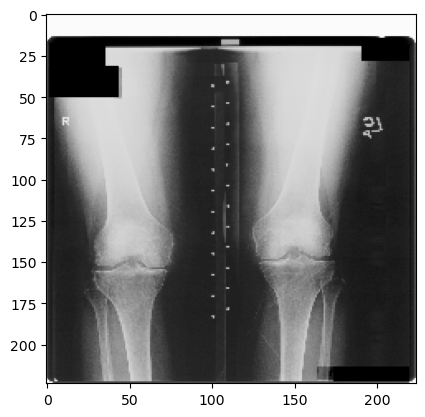

In [2]:
def view_xray(path: str) -> None:
    """View xray based on image path."""

    img_array = np.load(path)
    plt.imshow(img_array, cmap="gray")
    plt.show()


view_xray(os.path.join(REMOTE_IMAGE_DIR, "01260803.npy"))


In [179]:
class BBox(object):
    def __init__(self, x1, y1, x2, y2):
        """Bounding box wrapper class.

        (x1, y1) is the upper left corner,
        (x2, y2) is the lower right corner,
        with (0, 0) being in the upper left corner.

        """
        if x1 > x2:
            x1, x2 = x2, x1
        if y1 > y2:
            y1, y2 = y2, y1

        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2

    def taxicab_diagonal(self):
        """Return the taxicab distance from (x1,y1) to (x2,y2)."""

        return self.x2 - self.x1 + self.y2 - self.y1

    def overlaps(self, other):
        """Return True iff self and other overlap."""

        return not (
            (self.x1 > other.x2)
            or (self.x2 < other.x1)
            or (self.y1 > other.y2)
            or (self.y2 < other.y1)
        )

    def area(self):
        """Get area of bounding box."""

        xwidth = self.x2 - self.x1
        ywidth = self.y2 - self.y1

        return xwidth * ywidth

    def percent_total_area(self, img_height=224, img_width=224):
        """Get percentage total area."""

        return self.area() / (img_height * img_width)

    def vertical_side(self):
        """Get box vertical position on image."""

        if self.y1 < 20:
            if self.y2 > 204:
                return "edge"
            return "top"

        if self.y2 > 204:
            return "bottom"

        return "indeterminate"

    def horizontal_side(self):
        """Get box horizontal position on image."""

        if self.x1 < 20:
            if self.x2 > 204:
                return "edge"
            return "left"

        if self.x2 > 204:
            return "right"

        return "indeterminate"

    def __str__(self):
        return str(self.x1) + str(self.x2) + str(self.y1) + str(self.y2)

    def __hash__(self):
        return hash(str(self))

    def __eq__(self, other):
        if other == None:
            return False

        return (
            self.x1 == other.x1
            and self.y1 == other.y1
            and self.x2 == other.x2
            and self.y2 == other.y2
        )


def find_boxes(data, threshold):
    """Isolate boxes below threshold."""

    data = ndimage.uniform_filter(data, 5)

    thresh = data < threshold

    coded_boxes, _ = ndimage.label(thresh)

    filled = ndimage.morphology.binary_fill_holes(thresh)

    data_slices = ndimage.find_objects(coded_boxes)

    return data_slices


def slice_to_bbox(slices):
    """Convert ndimage slice object to box."""

    for s in slices:
        dy, dx = s[:2]
        yield BBox(dx.start, dy.start, dx.stop + 1, dy.stop + 1)


def largest_box(boxes):
    """Return largest bounding box below threshold."""

    largest = None

    for b in boxes:
        if not largest:
            largest = b

        if b.area() > largest.area():
            largest = b

    return largest


def largest_box_in_image(path: str, threshold=-1.15) -> int:
    """Find the largest black box in an image as percentage
    of total of area.
    """

    data = np.load(path)
    data_slices = find_boxes(data, threshold)
    bboxes = slice_to_bbox(data_slices)
    bbox = largest_box(bboxes)

    if bbox == None:
        return None

    area = bbox.area()

    return area / (data.shape[0] * data.shape[1])


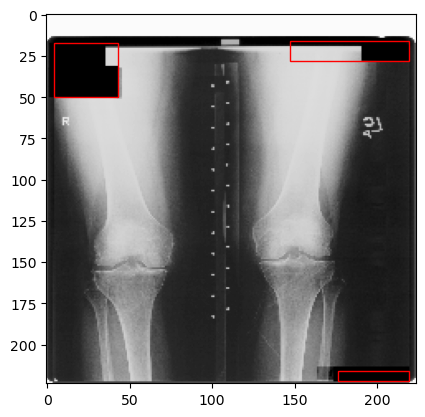

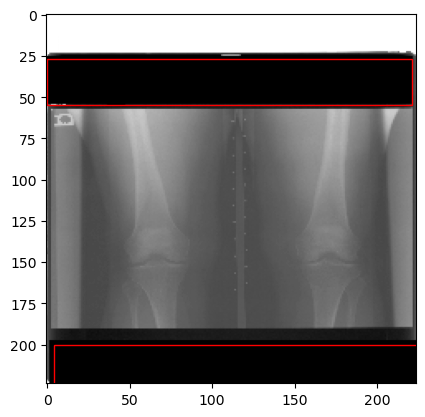

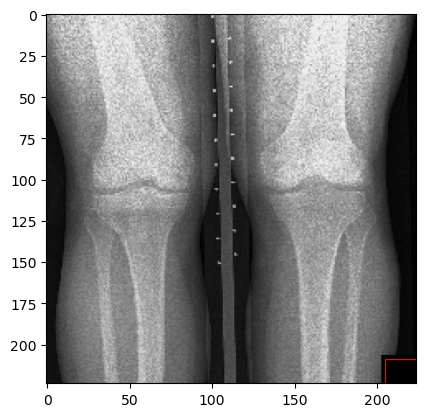

In [180]:
def view_xray_box(path: str) -> None:
    """View xray based on image path."""

    fig = plt.figure()
    ax = fig.add_subplot(111)
    data = np.load(path)

    im = ax.imshow(data, cmap="gray")

    data_slices = find_boxes(data, threshold=min(data.flatten()) + 0.01)

    bboxes = slice_to_bbox(data_slices)

    for bbox in bboxes:
        if bbox.percent_total_area() < SIZE_THRESHOLD:
            continue

        xwidth = bbox.x2 - bbox.x1
        ywidth = bbox.y2 - bbox.y1

        p = patches.Rectangle((bbox.x1, bbox.y1), xwidth, ywidth, fc="none", ec="red")
        ax.add_patch(p)

    plt.show()


view_xray_box(os.path.join(REMOTE_IMAGE_DIR, "01260803.npy"))
view_xray_box(os.path.join(REMOTE_IMAGE_DIR, "00969403.npy"))
view_xray_box(os.path.join(REMOTE_IMAGE_DIR, "01670901.npy"))


The above images show the algorithm finds boxes of low pixel values defined by a threshold.  Here the threshold is defined as the minimum pixel value plus a buffer.  The analysis can be reran using an absolute threshold. The image has some smoothing (using `uniform_filter`) applied so ndimage can more easily find objects in the mask.

In [263]:
boxes = []
image_aggregates = []
for _file in tqdm(os.listdir(REMOTE_IMAGE_DIR)):
    try:
        path = os.path.join(REMOTE_IMAGE_DIR, _file)
        data = np.load(path)
        data_slices = find_boxes(data, min(data.flatten()) + 0.01)
        bboxes = slice_to_bbox(data_slices)

        image_box_sum = 0
        edge_sum = 0
        box_count = 0

        for bbox in bboxes:
            total_area = bbox.percent_total_area()

            if bbox.percent_total_area() < SIZE_THRESHOLD:
                continue

            image_box_sum += total_area
            vertical_side = bbox.vertical_side()
            box_count += 1

            if vertical_side != "edge":
                edge_sum += total_area

            boxes.append(
                {
                    "path": path,
                    "image": _file.replace(".npy", ""),
                    "percent_total_area": bbox.percent_total_area(),
                    "horizontal_side": bbox.horizontal_side(),
                    "vertical_side": vertical_side,
                }
            )

        image_aggregates.append(
            {
                "path": path,
                "image": _file.replace(".npy", ""),
                "area_sum": image_box_sum,
                "area_sum_without_edges": edge_sum,
                "n_boxes": box_count,
            }
        )
    except:
        continue


df_images = pd.DataFrame(image_aggregates).sort_values(
    "area_sum_without_edges", ascending=False
)
df_images.to_csv(os.path.join(REMOTE_WD, "image_box_agg.csv"))

df_boxes = pd.DataFrame(boxes).sort_values("percent_total_area", ascending=False)
df_boxes.to_csv(os.path.join(REMOTE_WD, "boxes.csv"))


  0%|          | 0/26521 [00:00<?, ?it/s]

In [264]:
df_images.describe()


,area_sum,area_sum_without_edges,n_boxes
count,26520.000000,26520.000000,26520.000000
mean,0.089547,0.023387,1.669231
std,0.145382,0.045657,1.988356
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.003488,0.000000,1.000000
75%,0.166250,0.031614,3.000000
max,1.436045,0.878906,21.000000


Removing edges shows different distributions among the images. There are many more images where an xray edge (defined as the black box running the entired vertical edge) adds the majority of a boxed area.  These are often just the normal edges of an xray without corresponding signal and probably shouldn't be counted as signal.

In [265]:
df_boxes.describe()


,percent_total_area
count,44268.000000
mean,0.053646
std,0.070884
min,0.001016
25%,0.004125
50%,0.021325
75%,0.095344
max,1.008949


In [266]:
df_boxes[["vertical_side", "percent_total_area"]].groupby(["vertical_side"]).agg(
    ["mean", "count"]
)


percent_total_area       
                            mean  count
vertical_side                          
bottom                  0.026470  14835
edge                    0.138383  12679
indeterminate           0.006865   7539
top                     0.019076   9215

In [6]:
df_boxes[["horizontal_side", "percent_total_area"]].groupby(["horizontal_side"]).agg(
    ["mean", "count"]
)


percent_total_area       
                              mean  count
horizontal_side                          
edge                      0.398657    142
indeterminate             0.033264  18590
left                      0.064201  12693
right                     0.068900  12843

In [25]:
sum(df_images["area_sum_without_edges"] > 0.1) / len(df_images) * 100


7.043740573152338

Around 7% of all images have a non-edge box area of greater that 10%.

There are far fewer images where a horizontal box takes an entire edge.  This is actually a relatively rare occurrence.

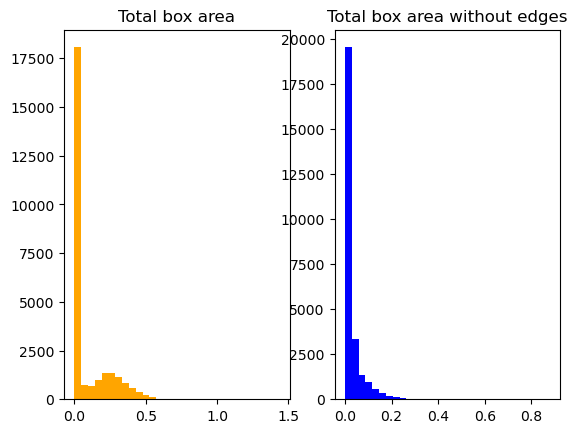

In [268]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.hist(df_images["area_sum"], bins=30, color="orange")
ax1.set_title("Total box area")

ax2.hist(df_images["area_sum_without_edges"], bins=30, color="blue")
ax2.set_title("Total box area without edges")

plt.show()


In [4]:
with open(DICOM_METADATA_PATH, "rb") as f:
    dicom_df = pickle.load(f)

dicom_df.head()


,"(0008, 0005) Specific Character Set","(0008, 0008) Image Type","(0008, 0012) Instance Creation Date","(0008, 0013) Instance Creation Time","(0008, 0016) SOP Class UID","(0008, 0018) SOP Instance UID","(0008, 0020) Study Date","(0008, 0022) Acquisition Date","(0008, 0030) Study Time","(0008, 0032) Acquisition Time",...,"(0020, 0052) Frame of Reference UID","(0040, 0250) Performed Procedure Step End Date","(0040, 0251) Performed Procedure Step End Time","(0018, 1170) Generator Power","(0018, 5020) Processing Function","(0018, 5021) Postprocessing Function","(0054, 0410) Patient Orientation Code Sequence","(0054, 0414) Patient Gantry Relationship Code Sequence","(0028, 0106) Smallest Image Pixel Value","(0028, 0107) Largest Image Pixel Value"
00700804,ISO_IR 100,"[DERIVED, PRIMARY]",20050513,091344,1.2.840.10008.5.1.4.1.1.1,1.3.6.1.4.1.21767.172.16.8.165.1158825987.343....,20050513,20050513,092624,092624,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04168501,ISO_IR 100,"[ORIGINAL, PRIMARY]",NaN,NaN,1.2.840.10008.5.1.4.1.1.1.1,1.3.6.1.4.1.21767.127.0.0.1.1377304274.0.0.1.1,20130806,20130806,142822,143521,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02127103,NaN,"[DERIVED, PRIMARY, POST_PROCESSED, , , , , , 1...",NaN,NaN,1.2.840.10008.5.1.4.1.1.1,1.3.6.1.4.1.21767.172.16.8.165.1183056852.849....,20070611,20070611,112952.000,113258.531,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03558001,ISO_IR 100,NaN,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,1.3.6.1.4.1.21767.127.0.0.1.1284501153.0.0.1.1,20100714,20100714,132755.000000,133249,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01597503,NaN,"[ORIGINAL, SECONDARY, RADIOGRAPH]",20060726,191749,1.2.840.10008.5.1.4.1.1.1,1.3.6.1.4.1.21767.172.16.8.182.1153941474.911....,20060707,20060707,000000,000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
dicom_df["(0028, 0034) Pixel Aspect Ratio"].describe()


count       1057
unique         1
top       [0, 0]
freq        1057
Name: (0028, 0034) Pixel Aspect Ratio, dtype: object

In [69]:
first_pixels = []
second_pixels = []
for sp in dicom_df["(0018, 1164) Imager Pixel Spacing"]:
    if type(sp) == list:
        first_pixels.append(sp[0])

        if len(sp) == 2:
            second_pixels.append(sp[1])
            continue
    elif type(sp) == str:
        sp = sp.split(" ")
        first_pixels.append(float(sp[0]))
        second_pixels.append(float(sp[1]))
        continue
    else:
        first_pixels.append(sp)

    second_pixels.append(pd.NA)

df_pixels = pd.DataFrame({"first": first_pixels, "second": second_pixels})


In [70]:
df_pixels["first"].dropna().describe()


count    24996.000000
mean         0.162415
std          0.033889
min          0.100000
25%          0.150000
50%          0.170000
75%          0.194000
max          0.200000
Name: first, dtype: float64

<AxesSubplot:ylabel='Density'>

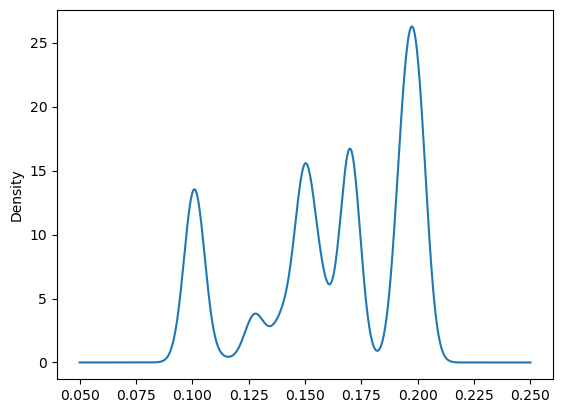

In [82]:
df_pixels["first"].dropna().plot(kind='density')



<AxesSubplot:ylabel='Density'>

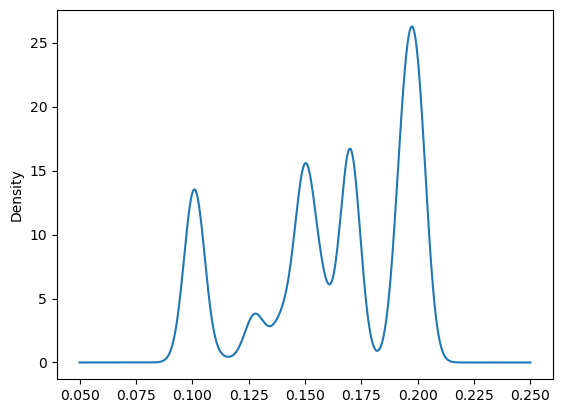

In [81]:
df_pixels["second"].dropna().astype("float").plot(kind='density')


Both the first and second pixels have similar mean values indicating square aspect ratios.  The distributions are relatively narrow although values are often omitted.